# Google Colab Upload

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/ImageCaptioning.zip /content/

In [3]:
!unzip ImageCaptioning.zip


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/285193181

In [4]:
!ls

captions.txt  drive  ImageCaptioning.zip  Images  sample_data


In [5]:
!ls /content

captions.txt  drive  ImageCaptioning.zip  Images  sample_data


In [6]:
image_dir = "/content/Images/"
caption_dir = "/content/captions.txt"

# Import Library

In [7]:
!pip install opencv-python-headless


In [8]:
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
import evaluate

from datetime import datetime
import re

from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import shutil

from PIL import Image
from transformers import ViTImageProcessor, TrainingArguments

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import GPT2Tokenizer, VisionEncoderDecoderModel, Trainer, EarlyStoppingCallback
from transformers import AutoImageProcessor
import sys

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)


# EDA

Text

In [9]:
df = pd.read_csv(caption_dir, sep=',', header=0, names=['image', 'caption'])
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [11]:
df.duplicated(subset=['image', 'caption']).sum()

np.int64(10)

In [12]:
df[df.duplicated(keep=False)]


image  \
7467   2305437797_e6c3460190.jpg   
7468   2305437797_e6c3460190.jpg   
7826   2335619125_2e2034f2c3.jpg   
7827   2335619125_2e2034f2c3.jpg   
9466   2441629086_52f68eb316.jpg   
9467   2441629086_52f68eb316.jpg   
14020  2737729252_b3fd9c05b1.jpg   
14021  2737729252_b3fd9c05b1.jpg   
23916  3262075846_5695021d84.jpg   
23917  3262075846_5695021d84.jpg   
25671  3337046794_296bd2c7e0.jpg   
25672  3337046794_296bd2c7e0.jpg   
26217  3355827928_c96c0c3e88.jpg   
26218  3355827928_c96c0c3e88.jpg   
31180  3552796830_2dd2aa9c2c.jpg   
31181  3552796830_2dd2aa9c2c.jpg   
35251  3730457171_e66dde8c91.jpg   
35252  3730457171_e66dde8c91.jpg   
37302   485741580_ab523fa657.jpg   
37303   485741580_ab523fa657.jpg   

                                                 caption  
7467          A dog swimming with a stick in its mouth .  
7468          A dog swimming with a stick in its mouth .  
7826           A black dog is running through the snow .  
7827           A black dog is running through the snow .  
9466                        A girl peers into a window .  
9467                        A girl peers into a window .  
14020  A girl is taking a picture of another girl in ...  
14021  A girl is taking a picture of another girl in ...  
23916                 A group of men are playing rugby .  
23917                 A group of men are playing rugby .  
25671               A black dog is digging in the snow .  
25672               A black dog is digging in the snow .  
26217                          A man on a bike in midair  
26218                          A man on a bike in midair  
31180  Two men in camouflage pants are running past a...  
31181  Two men in camouflage pants are running past a...  
35251                   A little girl rides a tricycle .  
35252                   A little girl rides a tricycle .  
37302                                   A dog in a car .  
37303                                   A dog in a car .

In [13]:
df = df.drop_duplicates(subset=['image', 'caption'])


In [14]:
df.duplicated(subset=['image', 'caption']).sum()

np.int64(0)

In [15]:
df['caption'].duplicated().sum()

np.int64(244)

In [16]:
df[df['caption'].duplicated(keep=False)].sort_values('caption')


image  \
19461  3068945309_ff0973e859.jpg   
21246  3154641421_d1b9b8c24c.jpg   
19675  3081182021_22cfa18dd4.jpg   
16775  2911552402_5166bc173b.jpg   
36775   458213442_12c59e61a0.jpg   
...                          ...   
31022  3547313700_39368b9a2f.jpg   
36603   446514680_ff5ca15ece.jpg   
3519   1778020185_1d44c04dae.jpg   
17691  2968182121_b3b491df85.jpg   
20046  3097196395_ec06075389.jpg   

                                                caption  
19461                A basketball player takes a shot .  
21246                A basketball player takes a shot .  
19675                  A biker does a trick on a ramp .  
16775                  A biker does a trick on a ramp .  
36775  A black and white dog is jumping over a hurdle .  
...                                                 ...  
31022                          two dogs play together .  
36603                          two dogs play together .  
3519                           two dogs play together .  
17691                  two dogs race across the track .  
20046                  two dogs race across the track .  

[431 rows x 2 columns]

Caption yang identik pada gambar yang berbeda dipertahankan karena merepresentasikan variasi visual dengan deskripsi semantik yang sama, yang umum ditemukan pada dataset image captioning. Jangan didrop

In [17]:
df['image'].duplicated().sum()

np.int64(32354)

In [18]:
df[df['image'].duplicated(keep=False)].sort_values('image')

image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40454  A rock climber practices on a rock climbing wa...  

[40445 rows x 2 columns]

Setiap gambar memiliki beberapa caption yang berbeda. Pendekatan multi-caption ini memungkinkan model mempelajari variasi deskripsi bahasa alami untuk representasi visual yang sama. jangan didrop

In [19]:
df.isnull().sum()

image      0
caption    0
dtype: int64

In [20]:
def get_unique_chars(series):
    chars = set()
    for text in series:
        chars.update(text)
    return sorted(chars)

caption_chars = get_unique_chars(df['caption'])

caption_chars

[' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

Tidak ada karakter aneh, selanjutnya bisa dilakukan tolower

In [21]:
df['caption'] = (
    df['caption']
    .str.lower()
    .str.replace(r'\s+([.,!?])', r'\1', regex=True)
)

In [22]:
df['caption'].head(5)

0    a child in a pink dress is climbing up a set o...
1                 a girl going into a wooden building.
2      a little girl climbing into a wooden playhouse.
3    a little girl climbing the stairs to her playh...
4    a little girl in a pink dress going into a woo...
Name: caption, dtype: object

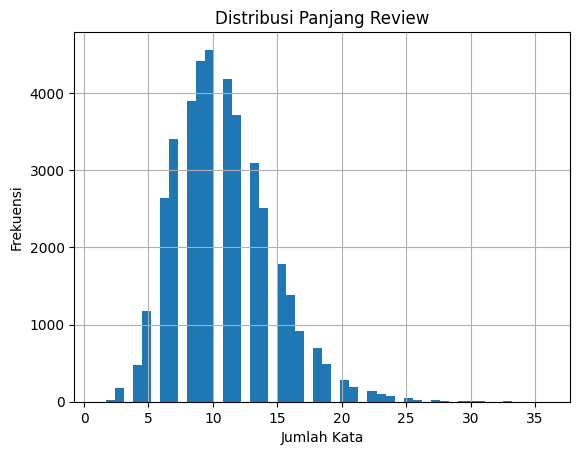

In [23]:
df['text_length'] = df['caption'].apply(lambda x : len(x.split()))

df['text_length'].hist(bins=50)
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Review')
plt.show()

Mayoritas caption berada di kisaran 8 - 12 kata, terdapat beberapa caption yang < 5 dan > 25

In [24]:
df[(df['text_length'] < 5) | (df['text_length'] > 25)]


image  \
184    1052358063_eae6744153.jpg   
306    1079274291_9aaf896cc1.jpg   
348    1088767354_2acee738cf.jpg   
364    1089181217_ee1167f7af.jpg   
419    1095590286_c654f7e5a9.jpg   
...                          ...   
40208    95151149_5ca6747df6.jpg   
40209    95151149_5ca6747df6.jpg   
40303    96420612_feb18fc6c6.jpg   
40346   972381743_5677b420ab.jpg   
40390   978580450_e862715aba.jpg   

                                                 caption  text_length  
184                                   two skateboarders.            2  
306                                 two boys make faces.            4  
348    the girl in the salmon colored bikini is stand...           27  
364                          energetic brown dog running            4  
419                              two dogs running around            4  
...                                                  ...          ...  
40208                                   rocky mountains.            2  
40209                                snow covered peaks.            3  
40303                         a shirtless man bodysurfs.            4  
40346  a girl dressed in black and white with mime ma...           28  
40390                              a blonde child swims.            4  

[760 rows x 3 columns]

Terdapat 760 kata, dibandingkan dengan 40.4k data, data tidak hilang terlalu banyak (1-2%). Oleh karena itu, boleh didrop

In [25]:
df = df[(df['text_length'] >= 5) & (df['text_length'] <= 25)]

In [26]:
df.head(5)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  text_length  
0  a child in a pink dress is climbing up a set o...           17  
1               a girl going into a wooden building.            7  
2    a little girl climbing into a wooden playhouse.            8  
3  a little girl climbing the stairs to her playh...            9  
4  a little girl in a pink dress going into a woo...           12

In [27]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

all_words = ' '.join(df['caption'].sample(5000).apply(clean_text)).split()
Counter(all_words).most_common(20)


[('a', 7977),
 ('in', 2409),
 ('the', 2373),
 ('on', 1328),
 ('is', 1220),
 ('and', 1104),
 ('with', 1007),
 ('dog', 1006),
 ('man', 930),
 ('of', 817),
 ('two', 672),
 ('white', 520),
 ('black', 491),
 ('boy', 479),
 ('are', 446),
 ('to', 431),
 ('girl', 426),
 ('woman', 411),
 ('at', 383),
 ('wearing', 361)]

Dominasi ada pada stop words seperti a, in, the. Stop words jangan dihapus

Terdapat kata dog & man. Oleh karena itu, Model harus jago dalam melihat human & animal features

Image

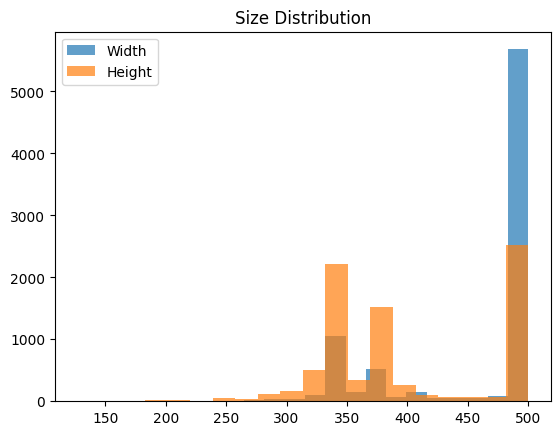

In [28]:
sizes = []

for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w, _ = img.shape
            sizes.append((w, h))

widths, heights = zip(*sizes)
plt.hist(widths, bins=20, alpha=0.7, label='Width')
plt.hist(heights, bins=20, alpha=0.7, label='Height')
plt.legend()
plt.title("Size Distribution")
plt.show()

Ukuran bervariasi terutama height dimana terdapat height < 300px sedikit. Solusinya lakukan resize dengan aspect ratio dan sisanya padding dengan mean pixel sampai menjadi 224 x 224

In [29]:
def resize_with_padding(img, target_size=224, pad_color=0):
    h, w = img.shape[:2]

    scale = target_size / max(h, w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized = cv2.resize(img, (new_w, new_h))

    pad_w = target_size - new_w
    pad_h = target_size - new_h

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        borderType=cv2.BORDER_CONSTANT,
        value=pad_color
    )

    return padded


In [30]:
img = cv2.imread(img_path)
img = resize_with_padding(img, 224)


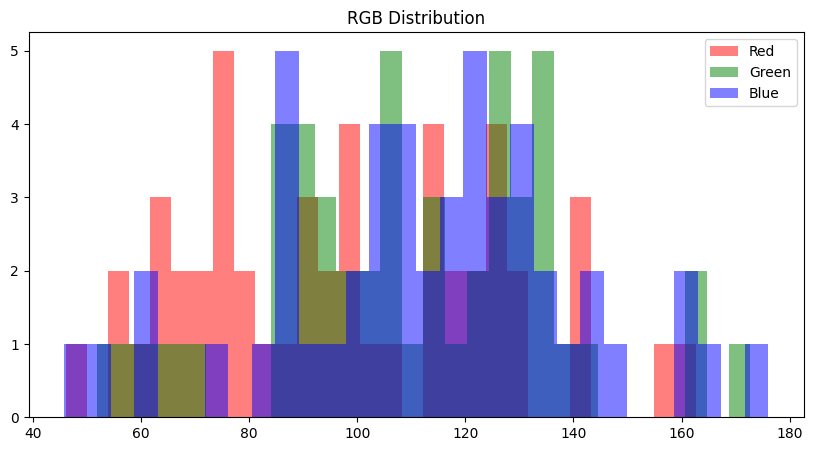

In [31]:
means = []
for img_name in os.listdir(image_dir)[:50]:
    img = cv2.imread(os.path.join(image_dir, img_name))
    if img is not None:
        means.append(cv2.mean(img)[:3])

means = np.array(means)
plt.figure(figsize=(10,5))
plt.hist(means[:,0], bins=30, color='r', alpha=0.5, label='Red')
plt.hist(means[:,1], bins=30, color='g', alpha=0.5, label='Green')
plt.hist(means[:,2], bins=30, color='b', alpha=0.5, label='Blue')
plt.legend()
plt.title("RGB Distribution")
plt.show()


Distribusi RGB menunjukkan bahwa nilai piksel tersebar secara cukup rata yang artinya dataset berkualitas baik. Selanjutnya akan dilakukan konversi ke RGB dan normalisasi pixel

In [32]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img = (img - mean) / std


Example

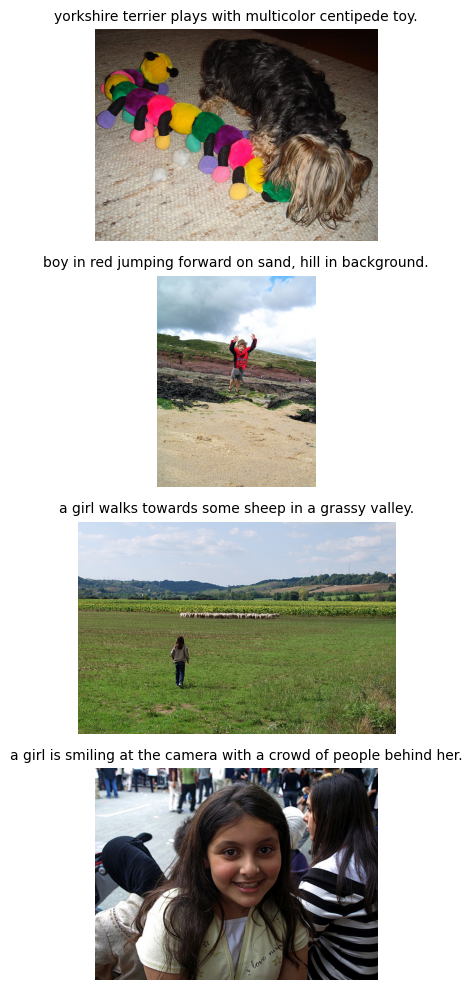

In [33]:
sample_df = df.sample(4,random_state=42)

plt.figure(figsize=(10, 10))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(image_dir, row['image'])
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = plt.subplot(4, 1, i + 1)
    plt.imshow(img)
    plt.title(row['caption'], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Preprocessing

In [35]:
image_processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224"
)

def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image_processor(images=image, return_tensors="pt")["pixel_values"].squeeze()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [36]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # penting!


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [37]:
def tokenize_caption(caption, max_length=25):
    tokens = tokenizer(
        caption,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return tokens.input_ids.squeeze()


In [38]:
image2captions = defaultdict(list)
for idx, row in df.iterrows():
    image2captions[row['image']].append(row['caption'])


In [39]:
images = list(image2captions.keys())
random.seed(42)
random.shuffle(images)

num_images = len(images)
train_split = int(0.8 * num_images)
val_split = int(0.9 * num_images)

train_images = images[:train_split]
val_images = images[train_split:val_split]
test_images = images[val_split:]


In [40]:
class FlickrDataset(Dataset):
    def __init__(self, image_list, image2captions, image_dir, tokenizer, max_length=50):
        self.images = image_list
        self.captions = image2captions
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        caption = random.choice(self.captions[img_name])  # pilih 1 caption random

        # proses image
        img_path = f"{self.image_dir}/{img_name}"
        pixel_values = process_image(img_path)

        # proses caption
        labels = tokenize_caption(caption, max_length=self.max_length)

        return {"pixel_values": pixel_values, "labels": labels}


In [41]:

train_dataset = FlickrDataset(train_images, image2captions, image_dir, tokenizer)
val_dataset = FlickrDataset(val_images, image2captions, image_dir, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# Pretrained Transformer

In [42]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224",
    "gpt2"
)


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224",
    "gpt2"
)

tokenizer.pad_token = tokenizer.eos_token

model.config.pad_token_id = tokenizer.eos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id

model.config.max_length = 25
model.config.min_length = 5



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'tran

In [43]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [44]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 239,195,904


In [45]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [46]:
# import evaluate

# bleu_metric = evaluate.load("bleu")

# def compute_metrics(pred):
#     labels_ids = pred.label_ids
#     pred_ids = pred.predictions

#     # decode
#     pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     labels_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

#     # BLEU expects references as list of list
#     references = [[l] for l in labels_str]  # setiap reference = 1 caption
#     predictions = pred_str

#     bleu = bleu_metric.compute(predictions=predictions, references=references)
#     return {"bleu": bleu["bleu"]}  # score BLEU 0-100


In [47]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    learning_rate=5e-5,
    logging_steps=50,
    eval_accumulation_steps=4,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)


In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

trainer.train()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 25, 'min_length': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].


TrainOutput(global_step=9708, training_loss=0.8421643908052323, metrics={'train_runtime': 2532.7748, 'train_samples_per_second': 51.106, 'train_steps_per_second': 6.388, 'total_flos': 1.401554763995362e+19, 'train_loss': 0.8421643908052323, 'epoch': 12.0})

Terlihat bahwa train-val loss ada yang naik turun, berarti adanya overfitting ringan

# Model Evaluation

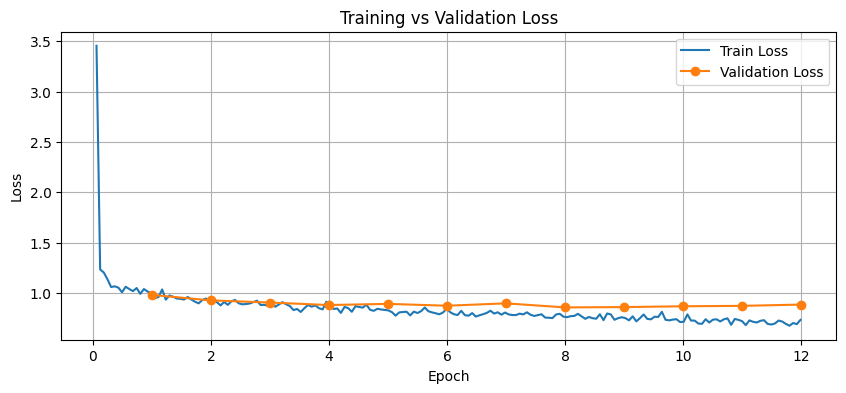

In [50]:
history = trainer.state.log_history

train_losses = []
train_steps = []

eval_losses = []
eval_epochs = []

for log in history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_losses.append(log["loss"])
        train_steps.append(log["epoch"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])


plt.figure(figsize=(10,4))
plt.plot(train_steps, train_losses, label="Train Loss")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00


In [66]:
test_dataset = FlickrDataset(test_images, image2captions, image_dir, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=16)

preds = []
refs = []

model.eval()
for batch in test_loader:
    pixel_values = batch["pixel_values"].unsqueeze(0) if len(batch["pixel_values"].shape)==3 else batch["pixel_values"]
    labels = batch["labels"]

    with torch.no_grad():
      device = model.device
      pixel_values = pixel_values.to(device)

      output_ids = model.generate(
          pixel_values=pixel_values,
          max_length=50,
          num_beams=4
      )

    for i in range(output_ids.size(0)):
            pred_str = tokenizer.decode(output_ids[i], skip_special_tokens=True)
            label_str = tokenizer.decode(labels[i], skip_special_tokens=True)

            preds.append(pred_str)
            refs.append([label_str])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [67]:
sacre_bleu = evaluate.load("sacrebleu")
bleu_score = sacre_bleu.compute(predictions=preds, references=refs)
print("Test SacreBLEU:", bleu_score["score"])

Test SacreBLEU: 0.19010936063297282


In [54]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a8471a6fc545655b7f34af83c29e8d858886f5e83e21154121a6290ee65500da
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [68]:
rouge = evaluate.load("rouge")
rouge_score = rouge.compute(
    predictions=preds,
    references=[r[0] for r in refs]
)

print("ROUGE Scores:")
print(f"ROUGE-1    : {rouge_score['rouge1']:.4f}")
print(f"ROUGE-2    : {rouge_score['rouge2']:.4f}")
print(f"ROUGE-L    : {rouge_score['rougeL']:.4f}")
print(f"ROUGE-Lsum : {rouge_score['rougeLsum']:.4f}")


ROUGE Scores:
ROUGE-1    : 0.2363
ROUGE-2    : 0.0082
ROUGE-L    : 0.2074
ROUGE-Lsum : 0.2069


In [56]:
!git clone https://github.com/salaniz/pycocoevalcap


Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 821 (delta 4), reused 3 (delta 3), pack-reused 809 (from 2)
Receiving objects: 100% (821/821), 130.06 MiB | 18.98 MiB/s, done.
Resolving deltas: 100% (424/424), done.


In [57]:
sys.path.append("pycocoevalcap")


In [69]:
preds_dict = {
    i: [preds[i]]
    for i in range(len(preds))
}

refs_dict = {
    i: refs[i]
    for i in range(len(refs))
}


In [70]:
from pycocoevalcap.cider.cider import Cider

cider_scorer = Cider()

cider_score, cider_scores = cider_scorer.compute_score(
    refs_dict,
    preds_dict
)

print("CIDEr score:", cider_score)


CIDEr score: 0.13817042884664282


In [71]:
meteor = evaluate.load("meteor")

meteor_score = meteor.compute(
    predictions=preds,
    references=[r[0] for r in refs]
)

print("METEOR Score:")
print(f"METEOR : {meteor_score['meteor']:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score:
METEOR : 0.1355


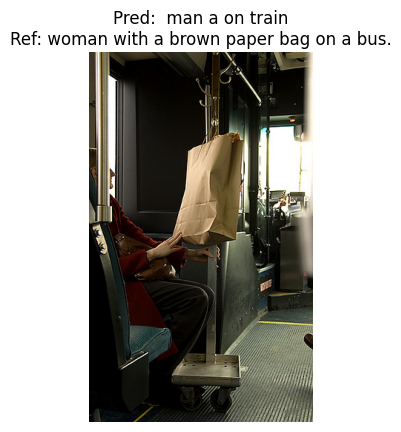

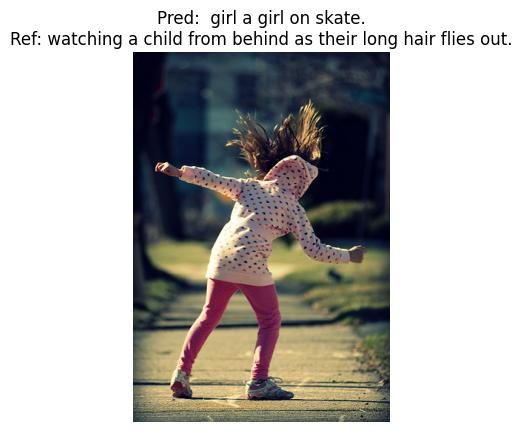

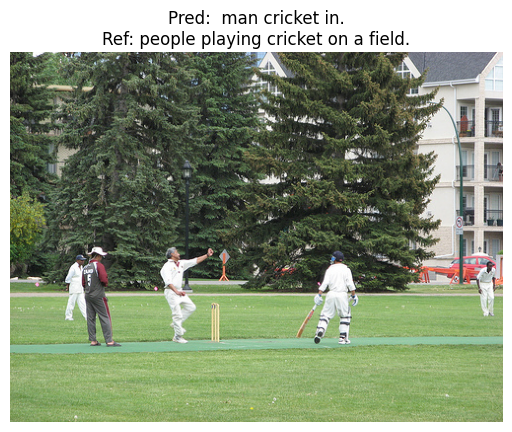

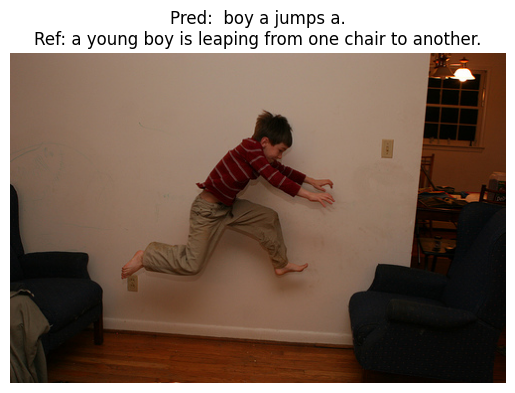

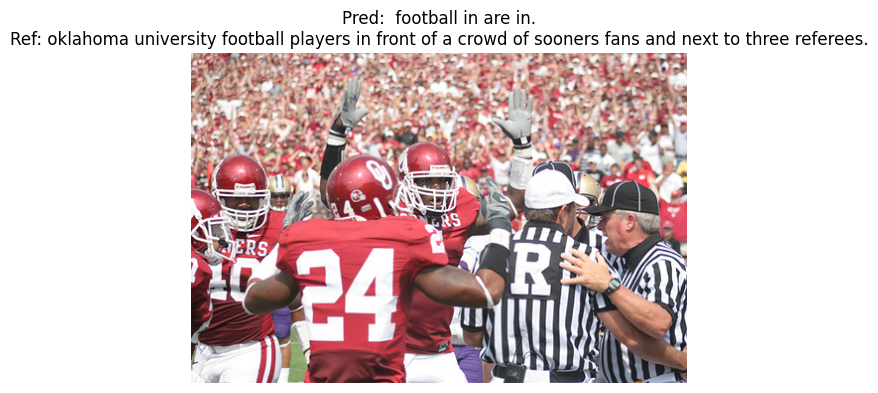

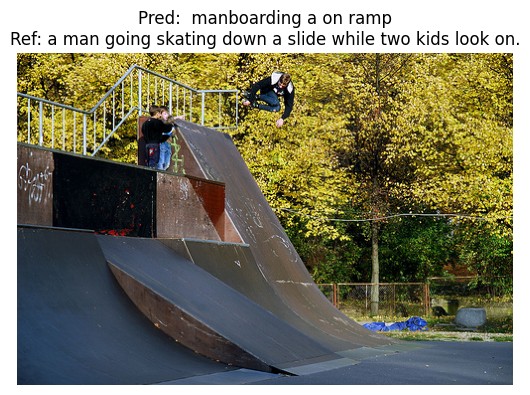

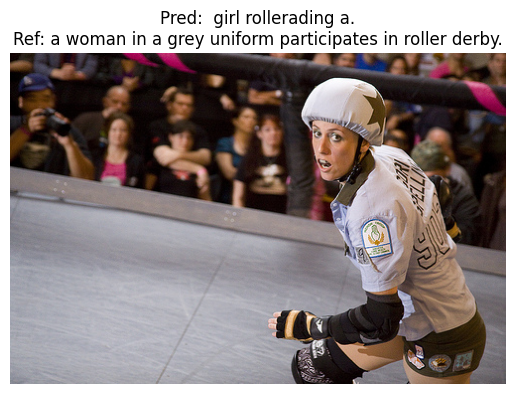

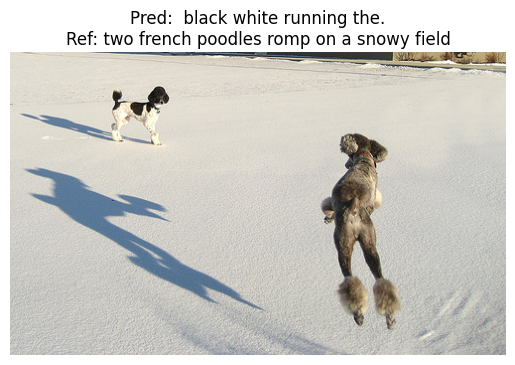

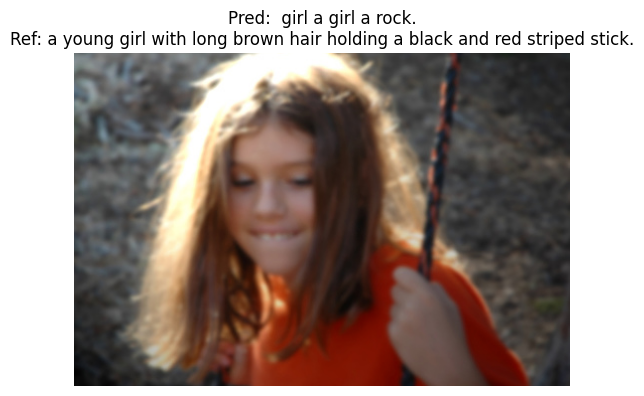

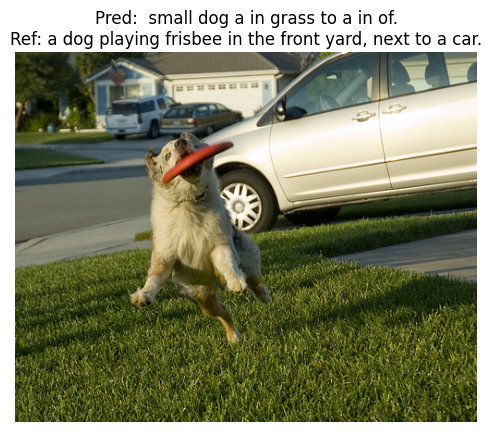

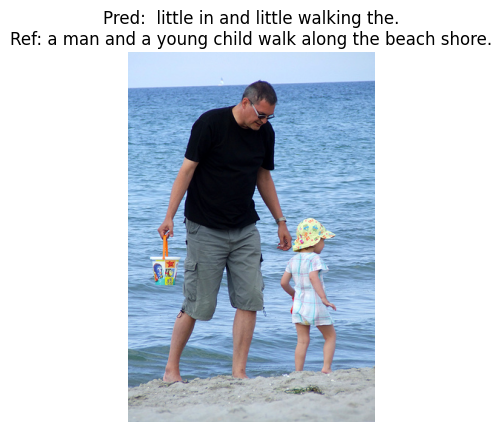

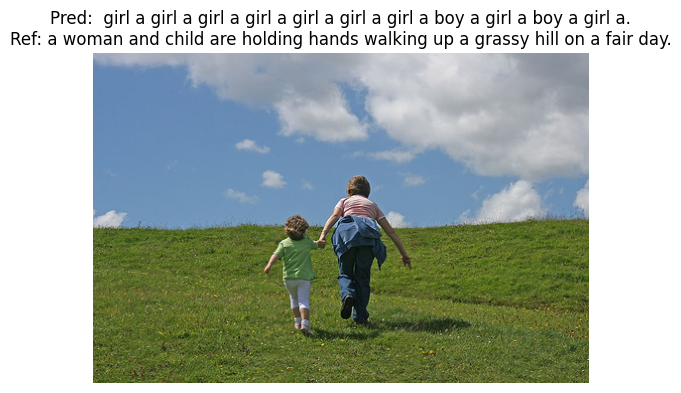

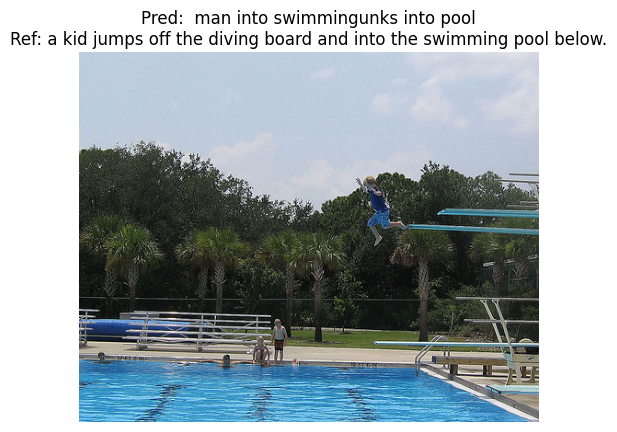

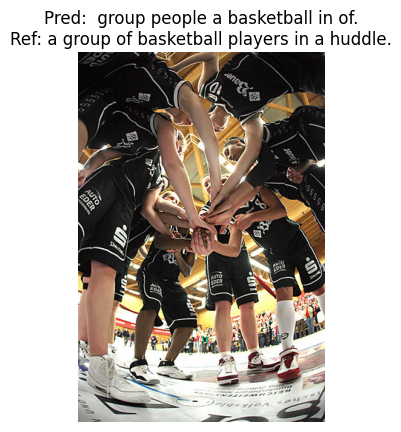

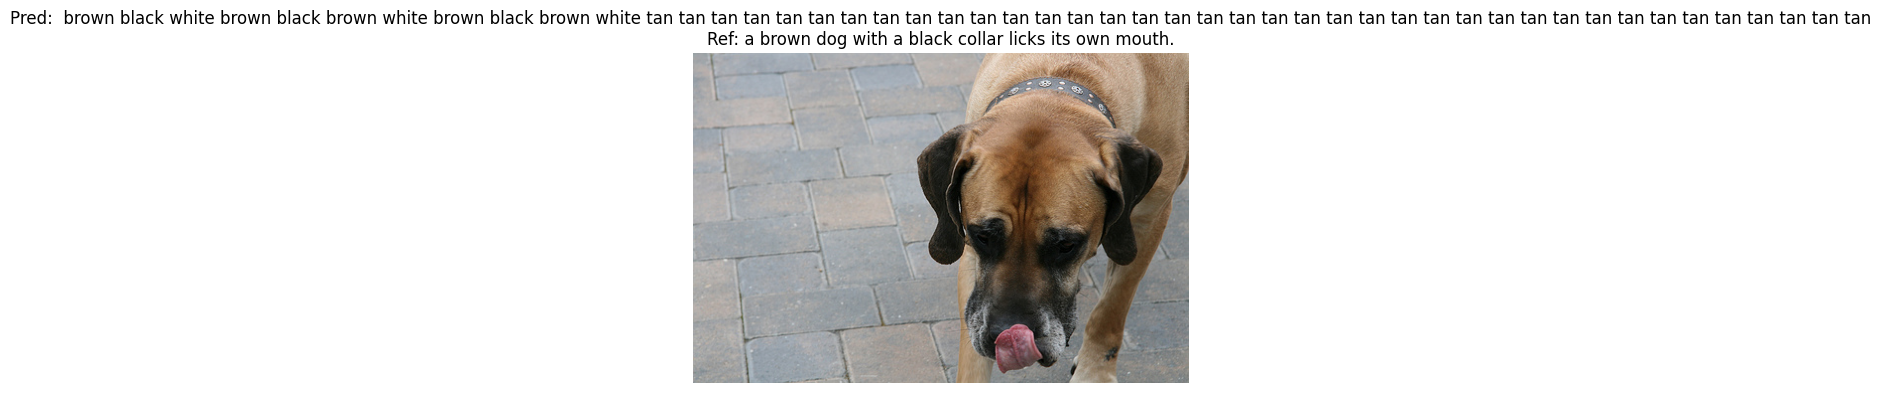

In [75]:
for i in range(15):
    img_path = f"{image_dir}/{test_images[i]}"
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {preds[i]}\nRef: {refs[i][0]}")
    plt.show()


Analisis Error Sekilas

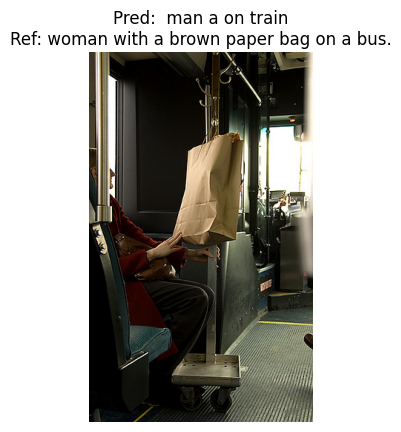

Pada prediksi pertama, Model memprediksi subjek sebagai man dan konteks sebagai train, sementara referensi menunjukkan woman yang membawa paper bag di dalam bus. Kesalahan ini mengindikasikan keterbatasan model dalam membedakan atribut halus seperti gender serta jenis kendaraan yang memiliki karakter visual serupa, serta kecenderungan menghasilkan caption yang lebih generik.

Solusi : Augmentasi data dengan variasi konteks transportasi, fine-tuning encoder visual secara lebih mendalam

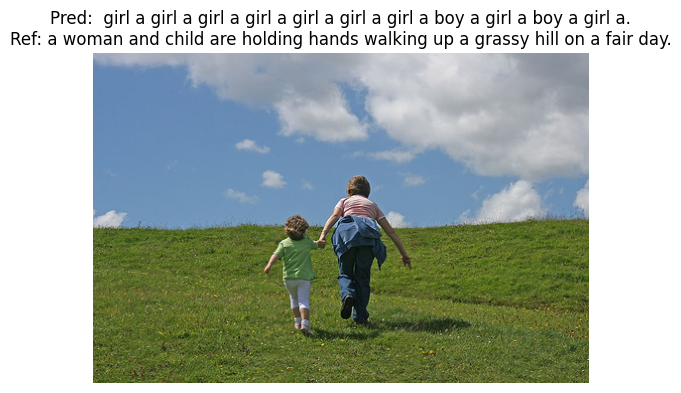

Pada prediksi ini, model menghasilkan caption yang berisi pengulangan kata girl dan boy, sementara referensi menunjukkan seorang woman dan child yang berjalan bersama sambil bergandengan tangan di area terbuka. Kesalahan ini berartgi bahwa model masih belum bisa membedakan kategori subjek manusia dan belum bisa memahami aksi yang dilakukan antar subjek.

Solusi : Tambah data yang berfokus pada relasi antar subjek manusia, fine tuning model

Interpretasi Metric

# SacreBLEU	0.1901

Metric ini menjelaskan seberapa banyak kata-kata dalam caption yang dihasilkan model sama dengan caption yang seharusnya. Nilai 0.1901 menunjukkan hanya sedikit kata yang cocok, artinya model kadang menangkap ide umum dari gambar, tetapi banyak kata penting dan detail hilang, sehingga caption kurang tepat.

# ROUGE-1	0.2363
Metric ini melihat kata-kata tunggal yang sama. Nilai metric hanya 0.2363 yang berarti model hanya menebak benar kurang dari 24% kata yang relevan, tapi model masih sering salah kata atau lupa menyebut hal penting di gambar.

# ROUGE-2	0.0082
Metric ini melihat dua kata berturut-turut yang sama. Nilainya Hampir nol yang berarti model hampir selalu salah membuat urutan kata yang benar.

# ROUGE-L / ROUGE-Lsum	0.2074 / 0.2069
Metric ini melihat seberapa banyak urutan kata panjang dari caption asli muncul di caption model. Nilainya ~20% yang berarti model kadang bisa menyusun sebagian kalimat benar, tetapi masih banyak yang salah urut atau hilang kata.

# CIDEr	0.1381
Metric ini melihat seberapa detail kata-kata yang dipilih model dibandingkan dengan keseluruhan dataset. Nilainya 0.1381 yang berarti masih cukup rendah yang berarti model masih memprediksi caption yang terlalu umum tanpa menangkap detail penting yang ada di gambar.

# METEOR	0.1355
Metric ini menilai apakah kata model mirip artinya dengan kata yang seharusnya. Nilai 0.1355 rendah ini menunjukkan model masih sering gagal menebak kata yang mirip dengan caption sebenarnya



# Dari metric yang di atas, bisa disimpulkan :

- Model mashi kesulitan menebak beberapa kata penting, masih sering salah urutan, dan kurang detail. Caption yang dihasilkanyapun masih terlalu umum, model masih belum dapat menangkap hal-hal detail di gambar.

- Hal ini mungkin karena dataset kecil (4.4k) yang membuat model belajar hanya terbatas.

# Kesimpulan

1. Model capture kata kunci tapi detail rendah

- 0.23 ROUGE-1 & 0.19 BLEU menunjukkan model masih sulit menebak beberapa kata penting, struktur dan detail caption juga masih jauh dari referensi.

2. Dataset terbatas membatasi kualitas

- Dengan 4.4k data, model overfit sehingga menghasilkan caption terlalu umum.
- Metric-metric, seperti METEOR / CIDEr, yang rendah menunjukkan model masih kurang akurat. Dataset Expansion mungkin pilihan yang bagus

3. Hal selanjutnya yang mungkin bisa meningkatkan performa

- Selain dataset expansion, mungkin dapat dilakukan augmentasi data (teks & gambar)
- Penambahan Epoch & penurunan learning rate secara bertahap mungkin dapat meningkatkan performa
- Selain itu, Fine-tuning ViT-GPT2 lebih hati-hati lagi juga penting, agar model tetap memanfaatkan pengetahuan pretrain tetapi tidak overfit pada dataset kecil.